# Analysis of June 13th 2022 Flight

Goal: 
1. Import the data one time
2. Plot in modifiable windows
3. Do basic analysis with static mask
4. Show results in pretty plots
5. Get preliminary results to compare with 2021 data!

In [8]:
### Definining name of analysis ###
name = '2022-06-28_CREATeV_2022-06-13_Analysis_1Hz'
data_path = '../data/'
data_folder = 'createv-2022-06-13'
file_name = 'june13_2022.BIN'
datasave_path = data_path+data_folder+'/'
result_path = '../Results/'+name+'/'
figure_path = '../Figures/'+name+'/'

## Importing Packages and Libraries

In [9]:
from os import sys
import os
sys.path.append('../')

%matplotlib widget

from matplotlib import pyplot as plt
import numpy as np
import pandas as pd

import main
from main import flight
from main import analysis
import propellers
import motors
from aircraft import airplane
import cl_finders

### Creating Folders for Results/Data ###
if not os.path.exists(result_path):
    os.makedirs(result_path)
if not os.path.exists(figure_path):
    os.makedirs(figure_path)
if not os.path.exists(data_path+data_folder):
    os.makedirs(data_path+data_folder)

# Setting Plot Defaults
plt.style.use('../basic_plotter.mplstyle')

## Importing Data at 1 Hz

In [10]:
# Importing data, specifying import characteristics, backing up results
rate = "1s"
interpolateM = "linear"
processor = "CREATeV_2022"

rawdata_name = data_folder+'/'+file_name.split('.')[0]+'_'+rate+'_'+interpolateM+'_'+processor+'.pkl'

# Checking if the data is already pickled for analysis
if os.path.exists(data_path+rawdata_name):
    df = pd.read_pickle(data_path+rawdata_name)
else:
    df = main.get_data(processor, data_folder+'/'+file_name, rate)
    df = df.interpolate(method=interpolateM)
    pd.to_pickle(df, data_path+rawdata_name) # Storing parsed data
    
#df = main.get_data("Alton", "june13_2022.BIN", '1s')

## Defining Vehicle parameters

In [11]:
# Vehicle parameters
prop = propellers.aeronaut20x8() # Using aeronaut 20x8 for this flight
motor = motors.U7V2_280KV()  # Using U7 V2 motor

mass = 12.7 # Estimated with virtual bolt included
span = 6.28
chord = 0.395
createv = airplane(mass, chord, span)

P_systems = 4 # Amount of power consumed by everything except the ESC & motor

## Manually Defining 1 Hz Mask

In [12]:
### Mask Initialization ###

mask = np.array([[5755,6340],
                [6350,6940],
                [6950,7540],
                [7550,8140],
                [8150,8740],
                [8750,9340],
                [9350,9940],
                [9950,10540]])

## Main Analysis: Getting P_req, CL, CD

In [13]:
############# Main Analysis ###############3

# Attitude 
phi = np.deg2rad(df["RollAngle"].to_numpy())                      # Bank angle in radians

# Atmospheric adjustments:
rho = df["Pressure"].to_numpy() * (287 * (df["Ambient_Temperature"].to_numpy()+273.15))**-1             # Density found from barometer pressure & airspeed sensor temperatures
v_eas = df["Airspeed_Sensor0"].to_numpy()                               # Equivalent SSL airspeed (m/s)
v_tas = v_eas * np.sqrt(1.225) * np.sqrt(rho)**-1   # the true airspeed
q = 0.5 * rho * v_tas**2                            # Dynamic pressure 

# Propulsion characterization
n = df["MotorRPM"].to_numpy() / 60                               # Revolutions per second
i_esc = df["EscCurrent"]
v_esc = df["EscVoltage"]
J = v_tas / (n * prop.diameter)

# Estimated propulsive power
P_eta = cl_finders.eta_steady(prop, motor, v_tas, n, i_esc, v_esc)
P_ct = cl_finders.thrust_steady(prop, rho, v_tas, n)

# Getting drag coefficient
Cd_eta = cl_finders.preq2cd(createv, v_tas, q, P_eta)
Cd_ct = cl_finders.preq2cd(createv, v_tas, q, P_ct)

# Getting lift coefficient
CL = cl_finders.cl_banked(createv, q, phi)

/var/folders/x_/hvhbycx15x31bybxtb1h9ktc0000gn/T/ipykernel_82312/3463579551.py:16: RuntimeWarning: divide by zero encountered in true_divide
  J = v_tas / (n * prop.diameter)
/var/folders/x_/hvhbycx15x31bybxtb1h9ktc0000gn/T/ipykernel_82312/3463579551.py:16: RuntimeWarning: invalid value encountered in true_divide
  J = v_tas / (n * prop.diameter)
/Users/williamkemp/Records/Repositories/CREATeV_AnalysisSuite/Investigations/../cl_finders.py:60: RuntimeWarning: divide by zero encountered in reciprocal
  J_tas = v_tas * (n * propeller.diameter)**-1             # Advance ratio at TAS
/Users/williamkemp/Records/Repositories/CREATeV_AnalysisSuite/Investigations/../cl_finders.py:60: RuntimeWarning: invalid value encountered in multiply
  J_tas = v_tas * (n * propeller.diameter)**-1             # Advance ratio at TAS
/Users/williamkemp/Records/Repositories/CREATeV_AnalysisSuite/Investigations/../motors.py:53: RuntimeWarning: divide by zero encountered in reciprocal
  efficiency = (1 - (i0/curre

### Averaging $C_L$, $C_D$, getting stats

In [14]:
# Averaging & Getting Stats
CDct_ave = np.zeros(len(mask))
CDeta_ave = np.zeros(len(mask))
CL_ave = np.zeros(len(mask))
EAS_ave = np.zeros(len(mask))

CDct_std = np.zeros(len(mask))
CDeta_std = np.zeros(len(mask))
CL_std = np.zeros(len(mask))

for i in range(len(mask)):
    
    CDeta_ave[i] = np.mean(Cd_eta[int(mask[i,0]):int(mask[i,1])])
    CDct_ave[i] = np.mean(Cd_ct[int(mask[i,0]):int(mask[i,1])])
    CL_ave[i] = np.mean(CL[int(mask[i,0]):int(mask[i,1])])
    EAS_ave[i] = np.mean(v_eas[int(mask[i,0]):int(mask[i,1])])
    
    CDeta_std[i] = np.std(Cd_eta[int(mask[i,0]):int(mask[i,1])])
    CDct_std[i] = np.std(Cd_ct[int(mask[i,0]):int(mask[i,1])])
    CL_std[i] = np.std(CL[int(mask[i,0]):int(mask[i,1])])

## Cruise Drag Polar Production
### Plotting CL, CD by segments

/var/folders/x_/hvhbycx15x31bybxtb1h9ktc0000gn/T/ipykernel_82312/1230429672.py:19: RuntimeWarning: Mean of empty slice.
  cl_means_cruise = [cl_total_cruise[digitized_cruise == i].mean() for i in range(1, len(bins))]
/Users/williamkemp/opt/anaconda3/envs/superwake-records/lib/python3.10/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/var/folders/x_/hvhbycx15x31bybxtb1h9ktc0000gn/T/ipykernel_82312/1230429672.py:21: RuntimeWarning: Mean of empty slice.
  cd_means_eta = [cd_total_eta[digitized_cruise == i].mean() for i in range(1, len(bins))]
/var/folders/x_/hvhbycx15x31bybxtb1h9ktc0000gn/T/ipykernel_82312/1230429672.py:22: RuntimeWarning: Mean of empty slice.
  cd_means_ct = [cd_total_ct[digitized_cruise == i].mean() for i in range(1, len(bins))]
/Users/williamkemp/opt/anaconda3/envs/superwake-records/lib/python3.10/site-packages/numpy/core/_methods.py:262: RuntimeWarning: Degrees of freedom <= 0 

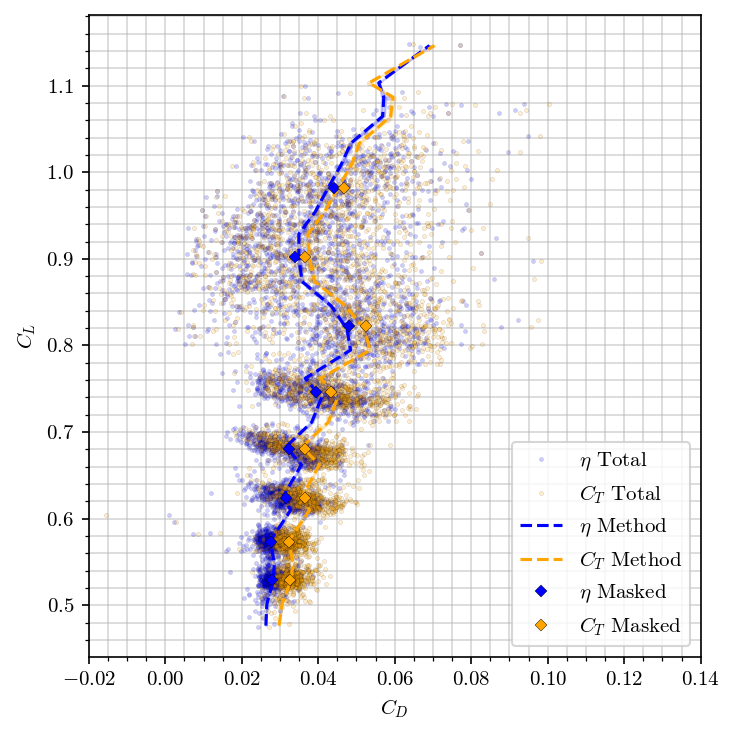

In [15]:
# Collecting all CL, CD data points for cruising, plotting with better visuals
def collect_segments(variable, mask_array):
    total = np.array([])
    for i in range(len(mask_array)):
        total = np.append(total, variable[mask_array[i,0]:mask_array[i,1]])
    return total

# Cruise drag data
cd_total_eta = collect_segments(Cd_eta, mask)
cd_total_ct = collect_segments(Cd_ct, mask)
# Cruise lift data
cl_total_cruise = collect_segments(CL, mask)

# Binning averages
bins = np.linspace(0.05, 1.4, 51)
digitized_cruise = np.digitize(cl_total_cruise, bins)

# Lift binning/averaging
cl_means_cruise = [cl_total_cruise[digitized_cruise == i].mean() for i in range(1, len(bins))]
# Drag averaging
cd_means_eta = [cd_total_eta[digitized_cruise == i].mean() for i in range(1, len(bins))]
cd_means_ct = [cd_total_ct[digitized_cruise == i].mean() for i in range(1, len(bins))]

# Lift standard deviation
cl_stds_cruise = [cl_total_cruise[digitized_cruise == i].std() for i in range(1, len(bins))]
# Drag standard deviation
cd_stds_eta = [cd_total_eta[digitized_cruise == i].std() for i in range(1, len(bins))]
cd_stds_ct = [cd_total_ct[digitized_cruise == i].std() for i in range(1, len(bins))]

# Calculation of confidence intervals
#cd_ci95_desc[i] = 1.96 * cd_stds_eta * (np.sqrt(len(Cd_ct[masks[i]])) **-1)
cd_ci95_eta = [ 1.96 * (np.sqrt(len(digitized_cruise == i)))**-1 * cd_total_eta[digitized_cruise == i].std() for i in range(1, len(bins)) ]
cd_ci95_ct = [ 1.96 * (np.sqrt(len(digitized_cruise == i)))**-1 * cd_total_ct[digitized_cruise == i].std() for i in range(1, len(bins)) ]

cl_ci95_cruise = [ 1.96 * (np.sqrt(len(digitized_cruise == i)))**-1 * cl_total_cruise[digitized_cruise == i].std() for i in range(1, len(bins)) ]

raw_ave_polarw_confint = plt.figure(figsize=(5,5), dpi=150)
plt.plot(cd_total_eta, cl_total_cruise, linestyle='', marker='.', color = 'blue', alpha = 0.2, label='$\eta$ Total')
plt.plot(cd_total_ct, cl_total_cruise, linestyle='', marker='.', color='orange', alpha = 0.2, label='$C_T$ Total')
plt.plot(cd_means_eta, cl_means_cruise, linestyle='--', color='blue', marker='', label='$\eta$ Method')
plt.plot(cd_means_ct, cl_means_cruise, linestyle='--', color='orange', marker='', label='$C_T$ Method')
plt.fill_betweenx(cl_means_cruise, np.array(cd_means_eta) - np.array(cd_ci95_eta), np.array(cd_means_eta) + np.array(cd_ci95_eta), color='blue', alpha=0.2)
plt.fill_betweenx(cl_means_cruise, np.array(cd_means_ct) - np.array(cd_ci95_ct), np.array(cd_means_ct) + np.array(cd_ci95_ct), color='orange', alpha=0.2)
# Plotting manually masked and averaged data points
plt.plot(CDeta_ave, CL_ave, linestyle='', marker='D', color = 'blue', label='$\eta$ Masked')
plt.plot(CDct_ave, CL_ave, linestyle='', marker='D', color='orange', label='$C_T$ Masked')

plt.legend()
plt.xlabel("$C_D$")
plt.ylabel("$C_L$")
plt.xlim([-0.02, 0.14])
plt.show()

main.save_figure(raw_ave_polarw_confint, f'{raw_ave_polarw_confint=}'.split('=')[0], figure_path, overwrite=True)

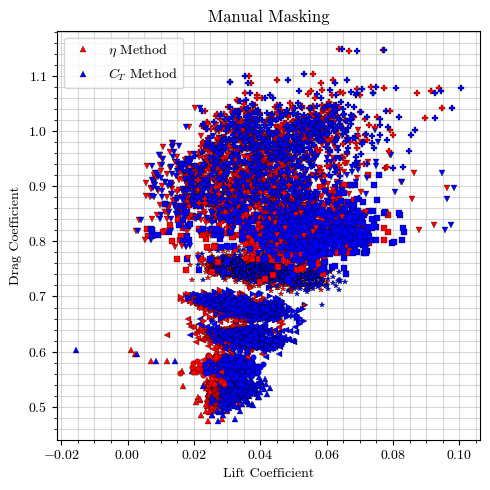

In [16]:
# Plot with static masking
plt.figure(figsize=(5,5))
plt.title("Manual Masking")
markers = ['^', 'o', '<', '>', '*', 's', 'v', 'P', 'X', 'D', 'H']
for i in range(len(mask)):
    plt.plot(Cd_eta[int(mask[i,0]):int(mask[i,1])], CL[int(mask[i,0]):int(mask[i,1])], linestyle='', marker=markers[i], markerfacecolor='r', markersize=4, markeredgecolor=[0,0,0])
    plt.plot(Cd_ct[int(mask[i,0]):int(mask[i,1])], CL[int(mask[i,0]):int(mask[i,1])], linestyle='', marker=markers[i], markerfacecolor='b', markersize=4, markeredgecolor=[0,0,0])
plt.xlabel("Lift Coefficient")
plt.ylabel("Drag Coefficient")
plt.legend(['$\eta$ Method', '$C_T$ Method'])
plt.show()

### Plotting Power Required, TAS, for segments

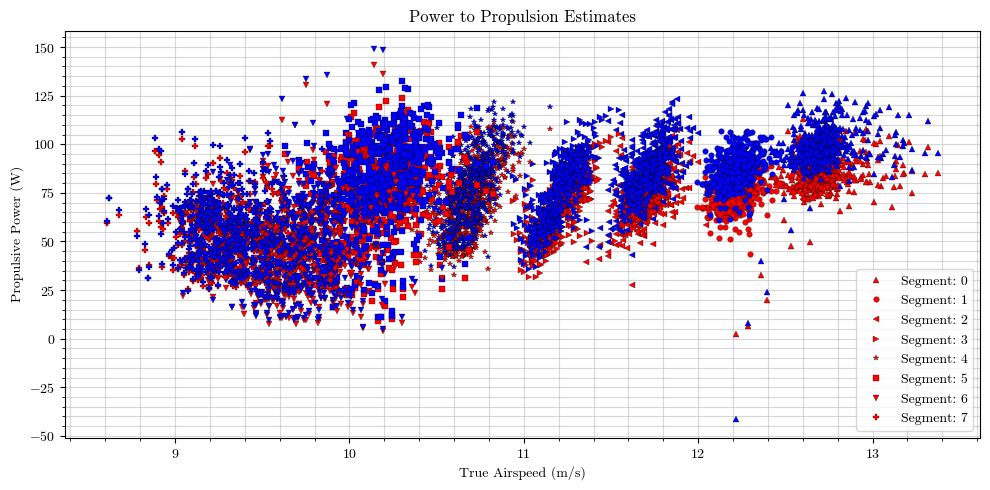

In [17]:
plt.figure(figsize=(10,5))
plt.title("Power to Propulsion Estimates")
for i in range(len(mask)):
    plt.plot(v_tas[int(mask[i,0]):int(mask[i,1])], P_eta[int(mask[i,0]):int(mask[i,1])], label="Segment: "+str(i), linestyle='', marker=markers[i], markerfacecolor='r', markersize=4, markeredgecolor=[0,0,0])
    plt.plot(v_tas[int(mask[i,0]):int(mask[i,1])], P_ct[int(mask[i,0]):int(mask[i,1])], linestyle='', marker=markers[i], markerfacecolor='b', markersize=4, markeredgecolor=[0,0,0])
plt.grid(True)
plt.xlabel("True Airspeed (m/s)")
plt.ylabel("Propulsive Power (W)")
plt.legend()
plt.show()

### Plotting Averaged Polar Results, by segment

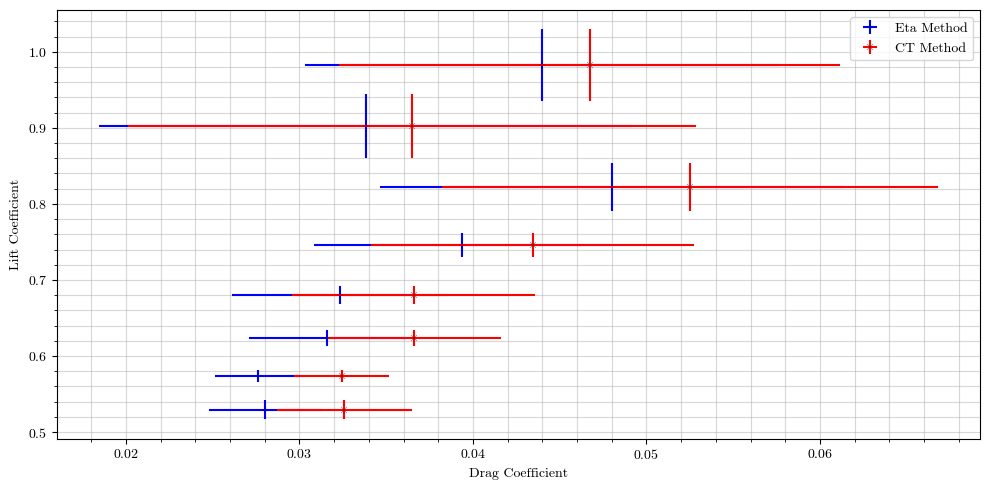

In [18]:
# Plotting 
plt.figure(figsize=(10,5))
plt.errorbar(CDeta_ave, CL_ave, xerr=CDeta_std, yerr=CL_std, fmt='+b', label="Eta Method")
plt.errorbar(CDct_ave, CL_ave, xerr=CDct_std, yerr=CL_std, fmt='xr', label="CT Method")
plt.xlabel("Drag Coefficient")
plt.ylabel("Lift Coefficient")
plt.legend()
plt.grid(True)
plt.show()

### Curve fitting polar

In [19]:
# Finding drag polar:
polar_eta = cl_finders.cd2polar(createv, CDeta_ave, CL_ave)
polar_ct = cl_finders.cd2polar(createv, CDct_ave, CL_ave)

### Standardized Power Required from Fit, plotting

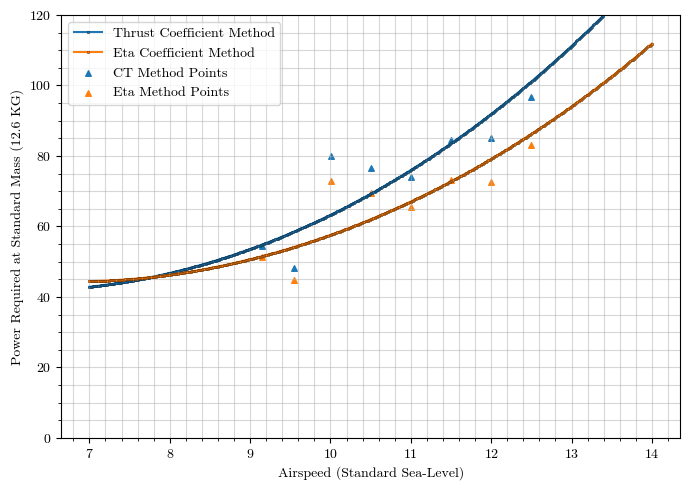

In [20]:
# Finding power required @ SSL @ Standard weight of 12.6 kg
Peq_eta, EAS = cl_finders.polar2preqew(createv, polar_eta, (7,14))
Peq_ct, EAS = cl_finders.polar2preqew(createv, polar_ct, (7,14))

plt.figure(figsize=(7,5))
plt.plot(EAS, Peq_ct, label="Thrust Coefficient Method")
plt.plot(EAS, Peq_eta, label="Eta Coefficient Method")
plt.scatter(EAS_ave, CDct_ave * 0.5 * 1.225 * EAS_ave**3 * createv.area, marker='^', label='CT Method Points')
plt.scatter(EAS_ave, CDeta_ave * 0.5 * 1.225 * EAS_ave**3 * createv.area, marker='^', label='Eta Method Points')
plt.xlabel("Airspeed (Standard Sea-Level)")
plt.ylabel("Power Required at Standard Mass (12.6 KG)")
plt.ylim([0,120])
plt.legend()
plt.grid(True)
plt.show()

## Time Indexed Plots
Used for segmenting the data, defining the mask used above.

### Plotting Motor RPM over selected time intervals

Text(0, 0.5, 'Motor Revolutions per Second')

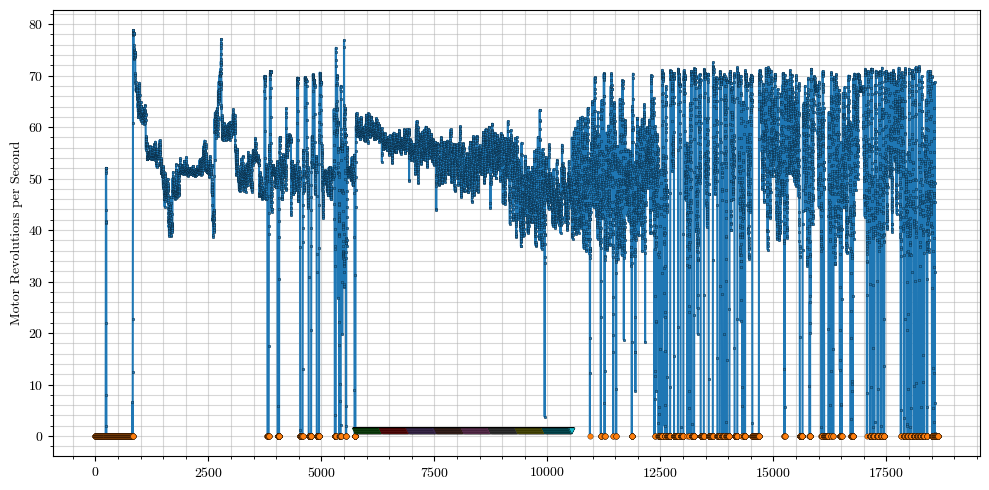

In [21]:
plt.figure(figsize=(10,5))
plt.plot(n)
plt.plot(np.transpose(np.where(n == 0)), n[n == 0], linestyle='None', marker='o')
for i in range(len(mask)):
    segment = np.arange(mask[i,0],mask[i,1])
    plt.plot(segment, np.ones(len(segment)), marker='v')
plt.grid(True)
plt.ylabel("Motor Revolutions per Second")

### Plotting Advance Ratio over selected time intervals

Text(0, 0.5, 'Advance Ratio')

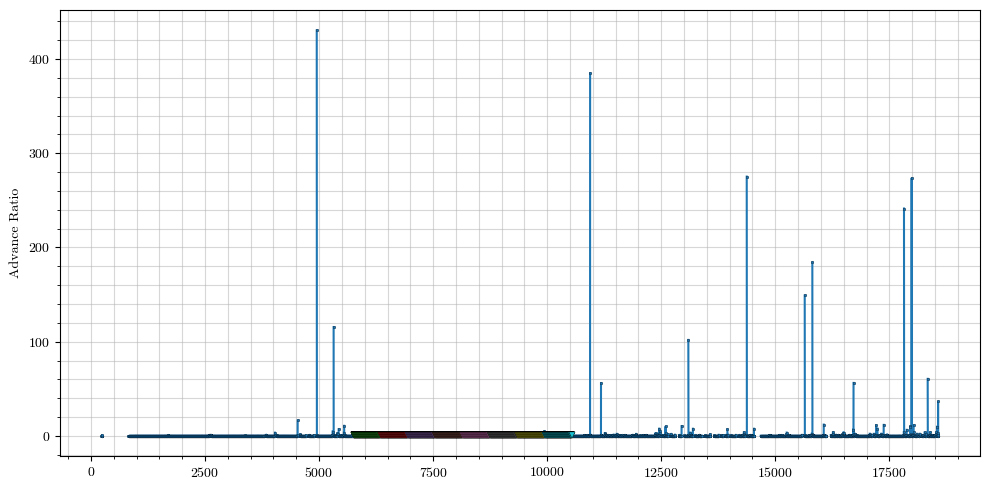

In [22]:
plt.figure(figsize=(10,5))
plt.plot(J)
plt.plot(np.transpose(np.where(n == 0)), J[n == 0], linestyle='None', marker='o')
for i in range(len(mask)):
    segment = np.arange(mask[i,0],mask[i,1])
    plt.plot(segment, np.ones(len(segment)), marker='v')
plt.grid(True)
plt.ylabel("Advance Ratio")